# Training AutoEncoder
In this file, we will train our GNN AutoEncoder. We will try two networks, one called Shallow GNN AutoEncoder which has one GNN layer in the encoder and one GNN layer in the decoder, and one called Deep GNN AutoEncoder which has two GNN layers in the encoder and two GNN layers in the decoder. For each of our networks we try 2 configurations. Finally, by comparing the test loss, we will choose the network and configuration with the lowest test loss and use it to create representations for each of our ontology concepts.

### Importing the needed packages

In [1]:
import os
import torch
from torch import nn
import torch.nn.functional as F
from torch_geometric.loader import DataLoader
from models import ShallowGNNAutoEncoder, DeepGNNAutoEncoder
from utils import ConceptGraphDataset
import math

In [2]:
cwd = os.getcwd()
path = os.path
pjoin = path.join
dataset = ConceptGraphDataset(root=cwd)

print()
print(f'Dataset: {dataset}:')
print('====================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')


Dataset: concept_graph():
Number of graphs: 6035
Number of features: 200


In [3]:
torch.manual_seed(12345)
dataset = dataset.shuffle()

train_size = math.ceil(len(dataset)*0.7)
last_train_index = math.ceil(train_size*0.7)
train_val_dataset = dataset[:train_size]
train_dataset = train_val_dataset[:last_train_index]
validation_dataset = train_val_dataset[last_train_index:]
test_dataset = dataset[train_size:]

print(f'Number of training graphs: {len(train_dataset)}')
print(f'Number of validation graphs: {len(validation_dataset)}')
print(f'Number of test graphs: {len(test_dataset)}')

Number of training graphs: 2958
Number of validation graphs: 1267
Number of test graphs: 1810


In [4]:
def train(model, train_data, validation_data, train_device, num_epochs=400, batch_size=64, learning_rate=1e-3):
    criterion = nn.MSELoss() # mean square error loss
    optimizer = torch.optim.Adam(model.parameters(),
                                 lr=learning_rate, 
                                 weight_decay=1e-5) # <--
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    train_outputs = []
    validation_outputs = []
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0
        for data in train_loader:
            data = data.to(device)
            out = model(data.x, data.edge_index)
            loss = criterion(out, data.x)
            loss.backward()  # Derive gradients.
            optimizer.step()  # Update parameters based on gradients.
            optimizer.zero_grad()  # Clear gradients.
            running_loss += loss.item()
        
        epoch_train_loss = running_loss/len(train_loader)
        epoch_validation_loss = test(model, validation_data, train_device, batch_size=batch_size)
        train_outputs.append(epoch_train_loss)
        validation_outputs.append(epoch_validation_loss)
        if ((epoch+1) % 50) == 0:
            epoch_info = ' Epoch:{}, Training Loss:{:.4f}, Validation Loss:{:.4f}'.format(epoch+1, epoch_train_loss, epoch_validation_loss)
            print(epoch_info.center(len(epoch_info) + 20, '='))
    return train_outputs, validation_outputs

In [5]:
def test(model, test_data, test_device, batch_size=64):
    model.eval()

    correct = 0
    true_classes = []
    predicted_classes = []
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)
    running_loss = 0
    for data in test_loader:  # Iterate in batches over the training/test dataset.
        data = data.to(test_device)
        out = model(data.x, data.edge_index)
        loss = F.mse_loss(data.x, out)
        running_loss += loss.item()
    return running_loss / len(test_loader)

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
batch = 64
epochs = 500
num_node_features = dataset.num_node_features

print(f'Training will be done on {device}')

Training will be done on cuda:0


### Training the first shallow model

In [7]:
first_shallow_ae = ShallowGNNAutoEncoder(in_channels=num_node_features, bottleneck_channels=128)
first_shallow_ae = first_shallow_ae.to(device)
print(first_shallow_ae)

ShallowGNNAutoEncoder


In [8]:
first_sh_train_outputs, first_sh_validation_outputs = train(first_shallow_ae, train_dataset, validation_dataset, device, num_epochs=epochs, batch_size=batch)
first_sh_final_validation_outputs = test(first_shallow_ae, validation_dataset, device, batch_size=batch)

========== Epoch:50, Training Loss:0.0009, Validation Loss:0.0009==========
========== Epoch:100, Training Loss:0.0010, Validation Loss:0.0009==========
========== Epoch:150, Training Loss:0.0009, Validation Loss:0.0009==========
========== Epoch:200, Training Loss:0.0009, Validation Loss:0.0009==========
========== Epoch:250, Training Loss:0.0010, Validation Loss:0.0009==========
========== Epoch:300, Training Loss:0.0009, Validation Loss:0.0009==========
========== Epoch:350, Training Loss:0.0009, Validation Loss:0.0009==========
========== Epoch:400, Training Loss:0.0009, Validation Loss:0.0009==========
========== Epoch:450, Training Loss:0.0009, Validation Loss:0.0009==========
========== Epoch:500, Training Loss:0.0009, Validation Loss:0.0009==========


### Training the second shallow model

In [9]:
second_shallow_ae = ShallowGNNAutoEncoder(in_channels=num_node_features, bottleneck_channels=64)
second_shallow_ae = second_shallow_ae.to(device)
print(second_shallow_ae)

ShallowGNNAutoEncoder


In [10]:
second_sh_train_outputs, second_sh_validation_outputs = train(second_shallow_ae, train_dataset, validation_dataset, device, num_epochs=epochs, batch_size=batch)
second_sh_final_validation_outputs = test(second_shallow_ae, validation_dataset, device, batch_size=batch)

========== Epoch:50, Training Loss:0.0009, Validation Loss:0.0009==========
========== Epoch:100, Training Loss:0.0009, Validation Loss:0.0009==========
========== Epoch:150, Training Loss:0.0009, Validation Loss:0.0009==========
========== Epoch:200, Training Loss:0.0010, Validation Loss:0.0009==========
========== Epoch:250, Training Loss:0.0010, Validation Loss:0.0009==========
========== Epoch:300, Training Loss:0.0009, Validation Loss:0.0009==========
========== Epoch:350, Training Loss:0.0009, Validation Loss:0.0009==========
========== Epoch:400, Training Loss:0.0009, Validation Loss:0.0009==========
========== Epoch:450, Training Loss:0.0009, Validation Loss:0.0009==========
========== Epoch:500, Training Loss:0.0009, Validation Loss:0.0009==========


### Training the first deep model

In [11]:
first_deep_ae = DeepGNNAutoEncoder(in_channels=num_node_features, middle_channels=128, bottleneck_channels=64)
first_deep_ae = first_deep_ae.to(device)
print(first_deep_ae)

DeepGNNAutoEncoder


In [12]:
first_dp_train_outputs, first_dp_validation_outputs = train(first_deep_ae, train_dataset, validation_dataset, device, num_epochs=epochs, batch_size=batch)
first_dp_final_validation_outputs = test(first_deep_ae, validation_dataset, device, batch_size=batch)

========== Epoch:50, Training Loss:0.0013, Validation Loss:0.0013==========
========== Epoch:100, Training Loss:0.0013, Validation Loss:0.0013==========
========== Epoch:150, Training Loss:0.0013, Validation Loss:0.0013==========
========== Epoch:200, Training Loss:0.0013, Validation Loss:0.0013==========
========== Epoch:250, Training Loss:0.0013, Validation Loss:0.0013==========
========== Epoch:300, Training Loss:0.0013, Validation Loss:0.0013==========
========== Epoch:350, Training Loss:0.0013, Validation Loss:0.0013==========
========== Epoch:400, Training Loss:0.0013, Validation Loss:0.0013==========
========== Epoch:450, Training Loss:0.0013, Validation Loss:0.0013==========
========== Epoch:500, Training Loss:0.0013, Validation Loss:0.0013==========


### Training the second deep model

In [13]:
second_deep_ae = DeepGNNAutoEncoder(in_channels=num_node_features, middle_channels=64, bottleneck_channels=32)
second_deep_ae = second_deep_ae.to(device)
print(second_deep_ae)

DeepGNNAutoEncoder


In [14]:
second_dp_train_outputs, second_dp_validation_outputs = train(second_deep_ae, train_dataset, validation_dataset, device, num_epochs=epochs, batch_size=batch)
second_dp_final_validation_outputs = test(second_deep_ae, validation_dataset, device, batch_size=batch)

========== Epoch:50, Training Loss:0.0014, Validation Loss:0.0013==========
========== Epoch:100, Training Loss:0.0013, Validation Loss:0.0013==========
========== Epoch:150, Training Loss:0.0013, Validation Loss:0.0013==========
========== Epoch:200, Training Loss:0.0013, Validation Loss:0.0013==========
========== Epoch:250, Training Loss:0.0013, Validation Loss:0.0013==========
========== Epoch:300, Training Loss:0.0013, Validation Loss:0.0013==========
========== Epoch:350, Training Loss:0.0013, Validation Loss:0.0013==========
========== Epoch:400, Training Loss:0.0013, Validation Loss:0.0013==========
========== Epoch:450, Training Loss:0.0013, Validation Loss:0.0013==========
========== Epoch:500, Training Loss:0.0013, Validation Loss:0.0013==========


### Comparing the results

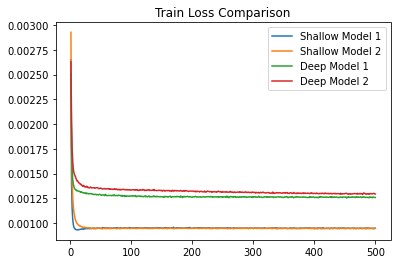

In [16]:
import matplotlib.pyplot as plt
  
epochs_list = range(1, epochs+1)
plt.plot(epochs_list, first_sh_train_outputs, label = "Shallow Model 1")
plt.plot(epochs_list, second_sh_train_outputs, label = "Shallow Model 2")
plt.plot(epochs_list, first_dp_train_outputs, label = "Deep Model 1")
plt.plot(epochs_list, second_dp_train_outputs, label = "Deep Model 2")
plt.title("Train Loss Comparison")
plt.legend()
plt.savefig(pjoin(cwd, 'data', 'ae_train_loss_comparison'))
plt.show()

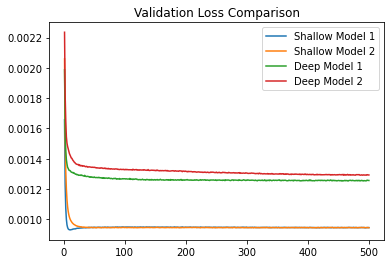

In [17]:
plt.plot(epochs_list, first_sh_validation_outputs, label = "Shallow Model 1")
plt.plot(epochs_list, second_sh_validation_outputs, label = "Shallow Model 2")
plt.plot(epochs_list, first_dp_validation_outputs, label = "Deep Model 1")
plt.plot(epochs_list, second_dp_validation_outputs, label = "Deep Model 2")
plt.title("Validation Loss Comparison")
plt.legend()
plt.savefig(pjoin(cwd, 'data', 'ae_validation_loss_comparison'))
plt.show()

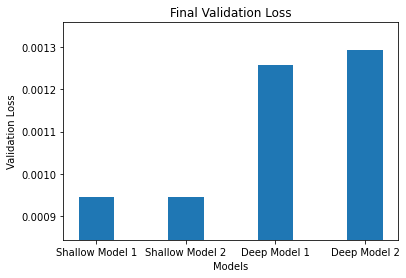

In [27]:
import numpy as np

x_bar = ['Shallow Model 1','Shallow Model 2','Deep Model 1','Deep Model 2']
y_bar = [first_sh_final_validation_outputs, second_sh_final_validation_outputs, first_dp_final_validation_outputs, second_dp_final_validation_outputs]
  
X_axis = np.arange(len(x_bar))
  
plt.bar(x_bar, y_bar, 0.4)
plt.ylim(bottom=(min(y_bar)-0.0001))
plt.xticks(X_axis, x_bar)
plt.xlabel("Models")
plt.ylabel("Validation Loss")
plt.title("Final Validation Loss")
plt.savefig(pjoin(cwd, 'data', 'ae_final_validation_loss_comparison'))
plt.show()

Based on the results above, the GNN autoencoders with only one GNN encoder layer and one GNN decoder layer have the lowest loss. These two are the candidate models

In [28]:
first_sh_test_outputs = test(first_shallow_ae, test_dataset, device, batch_size=batch)
second_sh_test_outputs = test(second_shallow_ae, test_dataset, device, batch_size=batch)
print(f'Shallow Model 1 Test Loss: {first_sh_test_outputs}')
print(f'Shallow Model 2 Test Loss: {second_sh_test_outputs}')

Shallow Model 1 Test Loss: 0.0009697778551871406
Shallow Model 2 Test Loss: 0.0009691768992242628


Based on the results above, Shallow Model 2 is slightly better, so it will be chosen and used to create the representations for each concept

In [29]:
torch.save(second_shallow_ae.state_dict(), pjoin(cwd, 'data', 'shallow_ae_64.pt'))